<a href="https://colab.research.google.com/github/balszeg/Deep_learning_uniproject/blob/main/Semester_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Milestone #1 ##


Importing the necessary libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
from IPython.display import clear_output

Cloning the chosen X-ray datasets into our content folder. Our goal is to predict if it depicts COVID-19 caused pneumonia or not. Initially, we'll use a smaller amount of data to find out which model is the most adaptable for our purposes.

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git
!git clone https://github.com/agchung/Figure1-COVID-chestxray-dataset.git
!git clone https://github.com/agchung/Actualmed-COVID-chestxray-dataset.git

os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip \*.zip  && rm *.zip

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.
fatal: destination path 'Figure1-COVID-chestxray-dataset' already exists and is not an empty directory.
fatal: destination path 'Actualmed-COVID-chestxray-dataset' already exists and is not an empty directory.
100% 1.15G/1.15G [00:15<00:00, 67.8MB/s]

Archive:  covid19-radiography-database.zip
  inflating: COVID-19 Radiography Database/COVID-19.metadata.xlsx  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (1).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (10).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (100).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (101).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (102).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (103).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (104).png  
  inflating: COVID-19 Radiography

Setting the path for the images, and reading there names in a list.

In [ ]:
image_path ='/content/covid-chestxray-dataset/images'
image_names=os.listdir(image_path)

Read the labels for the learning from a CSV file and put the names of the X-rays into an another list with the same order.


In [ ]:
x_raw_name=[] # the names of the pictures
y_label=[] # pcr test: True=+, False=-
images = [] # array for the actual images

with open('/content/covid-chestxray-dataset/metadata.csv') as csv_file: #load the csv from the session storage
    csv_reader = csv.reader(csv_file, delimiter=',') # ',' is the separating character
    line_count = 0 # line counter
    for row in csv_reader:
        if line_count == 0:
            # print("Images, PCR_test result") #the 0.th row is just a header
            line_count = 1
        else:
            if row[23] in image_names: # check if we have the x-ray image for this diagnosis
                if row[5]=='': # negative covid test
                  y_label.append(False)
                if row[5]=='Y': #positive covid test
                  y_label.append(True)
                if row[5]=='Y' or row[5]=='':
                  x_raw_name.append(row[23])
                  img = cv2.imread(image_path + '/' + x_raw_name[-1],0) # load the image
                  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) # resize the image to 224x224
                  images.append(img)
                  line_count += 1
    # print(f'Processed {line_count} lines.')
    print('As we can see we only have',f'{line_count-1} examples.')
    images = np.asarray(images)
    y_label = np.asarray(y_label)
    print('The shape of the np.array is: ',images.shape)

As we can see we only have 719 examples.
The shape of the np.array is:  (719, 224, 224)


Lets check some data now: all the images are 224x224 now

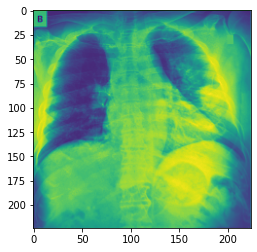

In [ ]:
plt.imshow(images[1]) # the most of the images are "front"

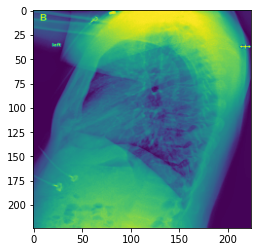

In [ ]:
plt.imshow(images[25]) #some of them has taken from the side.

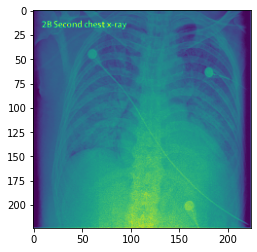

In [ ]:
plt.imshow(images[8]) # in some picture we can see wires and other medical equipments, it will might be hard to ignore and separate them from the important data: the pneumonia, during the deep learning
#the labels in the pictures also can cause some issue

Normalizing the images

In [ ]:
# "normalize" the images
normalized = images.astype(float)
for i in range(len(normalized)):
  normalized[i] = normalized[i]/255 # all pixel value between 0 and 1

## Milestone #2


First we are going to try a hand made CNN, see how it works.

Splitting the data into training, testing and validation sets

In [ ]:
# split the data into train, test, and validation arrays
x_train, x_2, y_train, y_2 = train_test_split(normalized, y_label, test_size=0.3, shuffle=True) # 70% of the data is the train data, 30% is for test and validation
x_valid, x_test, y_valid, y_test = train_test_split(x_2, y_2, test_size=0.33, shuffle=True) # Two thirds of the remaining 33% is the validation data and the remaining is for test
# shape of the arrays
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(503, 224, 224)
(144, 224, 224)
(72, 224, 224)
(503,)
(144,)
(72,)


Building and training of a self-designed CNN


In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn
from keras.models import load_model

In [ ]:
x_train = x_train.reshape(x_train.shape[0],224,224,1)
x_valid = x_valid.reshape(x_valid.shape[0],224,224,1)
x_test = x_test.reshape(x_test.shape[0],224,224,1)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (8, 8), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
checkpointer=ModelCheckpoint(filepath='HandMade.h5',save_best_only=True,verbose=1,) #We save the best model with checkpointer

In [ ]:
model.fit(x_train, y_train, epochs=30, batch_size=24, validation_data=(x_valid, y_valid),callbacks=[checkpointer,earlystopping])

Epoch 1/30
19/21 [==========================>...] - ETA: 0s - loss: 1.0572 - accuracy: 0.5022WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0029s vs `on_test_batch_end` time: 0.0050s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.69224, saving model to HandMade.h5
21/21 [==============================] - 1s 66ms/step - loss: 1.0233 - accuracy: 0.4970 - val_loss: 0.6922 - val_accuracy: 0.5417
Epoch 2/30
19/21 [==========================>...] - ETA: 0s - loss: 0.6891 - accuracy: 0.5373
Epoch 00002: val_loss improved from 0.69224 to 0.66696, saving model to HandMade.h5
21/21 [==============================] - 2s 109ms/step - loss: 0.6871 - accuracy: 0.5388 - val_loss: 0.6670 - val_accuracy: 0.6667
Epoch 3/30
19/21 [==========================>...] - ETA: 0s - loss: 0.6862 - accuracy: 0.5965
Epoch 00003: val_loss improved from 0.66696 to 0.66190, saving model to HandMade.h5
21/21 [=============================

Text(0.5, 1.0, 'HandMade')

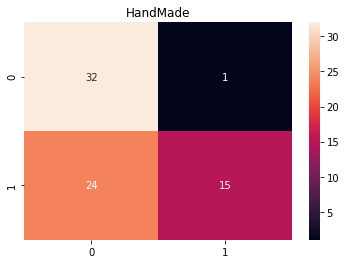

In [ ]:
model=load_model('HandMade.h5')
predict = model.predict(x_test) # predict the output for all test images
for i in range(len(predict)):
  if predict[i] > 0.5:
    predict[i] = 1
  else:
    predict[i] = 0
conf_matrix = confusion_matrix(y_test, predict) # create a confusion matrix from the model output and the correct solution of the test database
seaborn.heatmap(conf_matrix, annot=True) # show the results on a heatmap
plt.title('HandMade')

Now lets try some transfer learning. We are going to use these ImageNet pre-trained models: 

*   VGG16
*   VGG19
*   ResNet-50V2
*   ResNet-151V2
*   Xception
*   DenseNet121
*   MobilNetV2
*   InceptionResNetV2
*   InceptionV3

Prepare the data for the network's input

In [ ]:
#The input of this network is 3 chaneled RGB image, but we only have greyscale images. Lets just use our 1 chanel for each 3 RGB chanel to make it work.
print(len(normalized[:,0,0]))
print(len(normalized[0,:,0]))
print(len(normalized[0,0,:]))

triplechanel=np.zeros([len(normalized[:,0,0]),len(normalized[0,:,0]),len(normalized[0,0,:]),3]) #the shape of our new input

print('Our new input shape:', triplechanel.shape)
triplechanel[:,:,:,0], triplechanel[:,:,:,1], triplechanel[:,:,:,2] = normalized, normalized, normalized

719
224
224
Our new input shape: (719, 224, 224, 3)


In [ ]:
# split the data into train, test, and validation arrays
x_train, x_2, y_train, y_2 = train_test_split(triplechanel, y_label, test_size=0.3, shuffle=True) # 70% of the data is the train data, 30% is for test and validation
x_valid, x_test, y_valid, y_test = train_test_split(x_2, y_2, test_size=0.33, shuffle=True) # Two thirds of the remaining 33% is the validation data and the remaining is for test
# shape of the arrays
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(503, 224, 224, 3)
(144, 224, 224, 3)
(72, 224, 224, 3)
(503,)
(144,)
(72,)


In [ ]:
def TransferLearningModel(type):
  # loading the 'type' network, ensuring the head FC-layer sets are left off
  if type=='VGG16':
    baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='VGG19':
    baseModel = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='ResNet50V2':
    baseModel = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='ResNet152V2':
    baseModel = tf.keras.applications.ResNet152V2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='Xception':
    baseModel = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='DenseNet121':
    baseModel = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='MobilNetV2':
    baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='InceptionResNetV2':
    baseModel = tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='InceptionV3':
    baseModel = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  else:
    print('Wrong type, use valid pertrained keras model.')
  # construct the head of the model that will be placed on top of the the base model
  output = baseModel.output
  output = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(output) #first we use 2 layers MLP on the top of the pretrained CNN
  output = tf.keras.layers.Flatten(name="flatten")(output)
  output = tf.keras.layers.Dense(256, activation="relu")(output) # we are going to use the same MLPs as head, we will optimise them later
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(512, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(1, activation="sigmoid")(output)
  # place the head FC model on top of the base model
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model

In [ ]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 40
BATCHSIZE = 32 

# defining the optimizer
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS) #we always use thoose hyperparameters to check which pretrained CNN is the ebst for us.

STEP_TRAIN = len(x_train) // BATCHSIZE
STEP_VALID = len(x_valid) // BATCHSIZE

#1. VGG16

In [ ]:
model = TransferLearningModel('VGG16')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

Compiling model:
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 5

In [ ]:
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
checkpointer=ModelCheckpoint(filepath='VGG16.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[earlystopping,checkpointer])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 1.0378 - accuracy: 0.4875
Epoch 00001: val_loss improved from inf to 0.62940, saving model to VGG16.h5
15/15 [==============================] - 2s 102ms/step - loss: 1.0378 - accuracy: 0.4875 - val_loss: 0.6294 - val_accuracy: 0.6094
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.5393
Epoch 00002: val_loss did not improve from 0.62940
15/15 [==============================] - 1s 77ms/step - loss: 0.7292 - accuracy: 0.5393 - val_loss: 0.6316 - val_accuracy: 0.5391
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.5966
Epoch 00003: val_loss improved from 0.62940 to 0.57883, saving model to VGG16.h5
15/15 [==============================] - 1s 88ms/step - loss: 0.6630 - accuracy: 0.5966 - val_loss: 0.5788 - val_accuracy: 0.7422
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.5892 - accuracy: 0.6582
Epoch 00004: val_loss im

#2. VGG19

In [ ]:
model = TransferLearningModel('VGG19')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

80142336/80134624 [==============================] - 1s 0us/step
Compiling model:
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________

In [ ]:
checkpointer=ModelCheckpoint(filepath='VGG19.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 1.2190 - accuracy: 0.5229
Epoch 00001: val_loss improved from inf to 0.76636, saving model to VGG19.h5
15/15 [==============================] - 2s 120ms/step - loss: 1.2190 - accuracy: 0.5229 - val_loss: 0.7664 - val_accuracy: 0.5078
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.5372
Epoch 00002: val_loss improved from 0.76636 to 0.64725, saving model to VGG19.h5
15/15 [==============================] - 2s 106ms/step - loss: 0.7343 - accuracy: 0.5372 - val_loss: 0.6472 - val_accuracy: 0.6016
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5626
Epoch 00003: val_loss did not improve from 0.64725
15/15 [==============================] - 1s 91ms/step - loss: 0.6797 - accuracy: 0.5626 - val_loss: 0.6494 - val_accuracy: 0.6094
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.6200
Epoch 00004: val_loss i

#3. ResNet-50V2

In [ ]:
model = TransferLearningModel('ResNet50V2')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

94674944/94668760 [==============================] - 1s 0us/step
Compiling model:
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_____

In [ ]:
checkpointer=ModelCheckpoint(filepath='ResNet50V2.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 6.2090 - accuracy: 0.4750
Epoch 00001: val_loss improved from inf to 4.50265, saving model to ResNet50V2.h5
15/15 [==============================] - 2s 142ms/step - loss: 6.2090 - accuracy: 0.4750 - val_loss: 4.5026 - val_accuracy: 0.5781
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 3.2097 - accuracy: 0.6178
Epoch 00002: val_loss improved from 4.50265 to 0.91346, saving model to ResNet50V2.h5
15/15 [==============================] - 1s 99ms/step - loss: 3.2097 - accuracy: 0.6178 - val_loss: 0.9135 - val_accuracy: 0.6641
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.8450 - accuracy: 0.6858
Epoch 00003: val_loss improved from 0.91346 to 0.80850, saving model to ResNet50V2.h5
15/15 [==============================] - 5s 366ms/step - loss: 0.8450 - accuracy: 0.6858 - val_loss: 0.8085 - val_accuracy: 0.7422
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.56

#4 ResNet-152V2

In [ ]:
model = TransferLearningModel('ResNet152V2')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

234553344/234545216 [==============================] - 2s 0us/step
Compiling model:
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___

In [ ]:
checkpointer=ModelCheckpoint(filepath='ResNet152V2.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 5.6926 - accuracy: 0.5604
Epoch 00001: val_loss improved from inf to 0.98295, saving model to ResNet152V2.h5
15/15 [==============================] - 5s 362ms/step - loss: 5.6926 - accuracy: 0.5604 - val_loss: 0.9830 - val_accuracy: 0.7109
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 1.3386 - accuracy: 0.6008
Epoch 00002: val_loss improved from 0.98295 to 0.91340, saving model to ResNet152V2.h5
15/15 [==============================] - 5s 313ms/step - loss: 1.3386 - accuracy: 0.6008 - val_loss: 0.9134 - val_accuracy: 0.5703
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.6369
Epoch 00003: val_loss improved from 0.91340 to 0.66696, saving model to ResNet152V2.h5
15/15 [==============================] - 5s 324ms/step - loss: 0.7234 - accuracy: 0.6369 - val_loss: 0.6670 - val_accuracy: 0.7422
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 

# 5. Xception

In [ ]:
model = TransferLearningModel('Xception')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

Compiling model:
Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_____________________________________________________________________

In [ ]:
checkpointer=ModelCheckpoint(filepath='Xception.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 5.2116 - accuracy: 0.5021
Epoch 00001: val_loss improved from inf to 3.47889, saving model to Xception.h5
15/15 [==============================] - 3s 183ms/step - loss: 5.2116 - accuracy: 0.5021 - val_loss: 3.4789 - val_accuracy: 0.5078
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 1.3377 - accuracy: 0.5669
Epoch 00002: val_loss improved from 3.47889 to 0.59937, saving model to Xception.h5
15/15 [==============================] - 4s 243ms/step - loss: 1.3377 - accuracy: 0.5669 - val_loss: 0.5994 - val_accuracy: 0.6875
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.7704 - accuracy: 0.5796
Epoch 00003: val_loss improved from 0.59937 to 0.59875, saving model to Xception.h5
15/15 [==============================] - 2s 143ms/step - loss: 0.7704 - accuracy: 0.5796 - val_loss: 0.5987 - val_accuracy: 0.5703
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6266 - 

# 6. DenseNet121

In [ ]:
model = TransferLearningModel('DenseNet121')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

29089792/29084464 [==============================] - 0s 0us/step
Compiling model:
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____

In [ ]:
checkpointer=ModelCheckpoint(filepath='DenseNet121.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 5.4497 - accuracy: 0.4979
Epoch 00001: val_loss improved from inf to 1.60677, saving model to DenseNet121.h5
15/15 [==============================] - 3s 223ms/step - loss: 5.4497 - accuracy: 0.4979 - val_loss: 1.6068 - val_accuracy: 0.5078
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 1.0118 - accuracy: 0.6369
Epoch 00002: val_loss improved from 1.60677 to 0.55030, saving model to DenseNet121.h5
15/15 [==============================] - 2s 132ms/step - loss: 1.0118 - accuracy: 0.6369 - val_loss: 0.5503 - val_accuracy: 0.6875
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.6348
Epoch 00003: val_loss did not improve from 0.55030
15/15 [==============================] - 1s 68ms/step - loss: 0.5975 - accuracy: 0.6348 - val_loss: 0.5562 - val_accuracy: 0.6250
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.6263
Epoch 00004

# 7. MobilNetV2

In [ ]:
model = TransferLearningModel('MobilNetV2')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

9412608/9406464 [==============================] - 0s 0us/step
Compiling model:
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______

In [ ]:
checkpointer=ModelCheckpoint(filepath='MobilNetV2.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 6.1166 - accuracy: 0.5188
Epoch 00001: val_loss improved from inf to 0.89383, saving model to MobilNetV2.h5
15/15 [==============================] - 2s 119ms/step - loss: 6.1166 - accuracy: 0.5188 - val_loss: 0.8938 - val_accuracy: 0.6172
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7795 - accuracy: 0.5732
Epoch 00002: val_loss improved from 0.89383 to 0.57009, saving model to MobilNetV2.h5
15/15 [==============================] - 2s 136ms/step - loss: 0.7795 - accuracy: 0.5732 - val_loss: 0.5701 - val_accuracy: 0.6953
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.6200
Epoch 00003: val_loss improved from 0.57009 to 0.56386, saving model to MobilNetV2.h5
15/15 [==============================] - 1s 81ms/step - loss: 0.6370 - accuracy: 0.6200 - val_loss: 0.5639 - val_accuracy: 0.6875
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.60

# 8. InceptionResNetV2

In [ ]:
model = TransferLearningModel('InceptionResNetV2')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

Compiling model:
Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_232 (Conv2D)             (None, 111, 111, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_211 (BatchN (None, 111, 111, 32) 96          conv2d_232[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_211[0][0]    
_____________________________________________________________________

In [ ]:
checkpointer=ModelCheckpoint(filepath='InceptionResNetV2.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 6.1540 - accuracy: 0.5167
Epoch 00001: val_loss improved from inf to 1.07756, saving model to InceptionResNetV2.h5
15/15 [==============================] - 7s 468ms/step - loss: 6.1540 - accuracy: 0.5167 - val_loss: 1.0776 - val_accuracy: 0.5312
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.8664 - accuracy: 0.5308
Epoch 00002: val_loss improved from 1.07756 to 0.63847, saving model to InceptionResNetV2.h5
15/15 [==============================] - 4s 280ms/step - loss: 0.8664 - accuracy: 0.5308 - val_loss: 0.6385 - val_accuracy: 0.6484
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.5987
Epoch 00003: val_loss did not improve from 0.63847
15/15 [==============================] - 2s 134ms/step - loss: 0.6757 - accuracy: 0.5987 - val_loss: 0.7424 - val_accuracy: 0.6406
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.586

# 9. InceptionV3

In [ ]:
model = TransferLearningModel('InceptionV3')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

87916544/87910968 [==============================] - 0s 0us/step
Compiling model:
Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_435 (Conv2D)             (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_414 (BatchN (None, 111, 111, 32) 96          conv2d_435[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 111, 111, 32) 0           batch_normalization_414[0][0]    
____

In [ ]:
checkpointer=ModelCheckpoint(filepath='InceptionV3.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
14/15 [===========================>..] - ETA: 0s - loss: 7.0360 - accuracy: 0.5089
Epoch 00001: val_loss improved from inf to 0.73792, saving model to InceptionV3.h5
15/15 [==============================] - 3s 198ms/step - loss: 6.7261 - accuracy: 0.5104 - val_loss: 0.7379 - val_accuracy: 0.5625
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.5648
Epoch 00002: val_loss improved from 0.73792 to 0.66868, saving model to InceptionV3.h5
15/15 [==============================] - 2s 131ms/step - loss: 0.7533 - accuracy: 0.5648 - val_loss: 0.6687 - val_accuracy: 0.5469
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.5945
Epoch 00003: val_loss improved from 0.66868 to 0.63352, saving model to InceptionV3.h5
15/15 [==============================] - 2s 135ms/step - loss: 0.6744 - accuracy: 0.5945 - val_loss: 0.6335 - val_accuracy: 0.6484
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 

# Evaulation
 Lets take a closer look at the predicts

Plot the heatmaps of the test data prediction



In [ ]:
def MakeHeatmap(WeightsFile,X_test,Y_test):
  model=load_model(WeightsFile)
  predict = model.predict(X_test) # predict the output for all test images
  for i in range(len(predict)):
    if predict[i] > 0.5:
      predict[i] = 1
    else:
      predict[i] = 0
  conf_matrix = confusion_matrix(Y_test, predict) # create a confusion matrix from the model output and the correct solution of the test database
  seaborn.heatmap(conf_matrix, annot=True) # show the results on a heatmap
  plt.title(WeightsFile[0:-3])

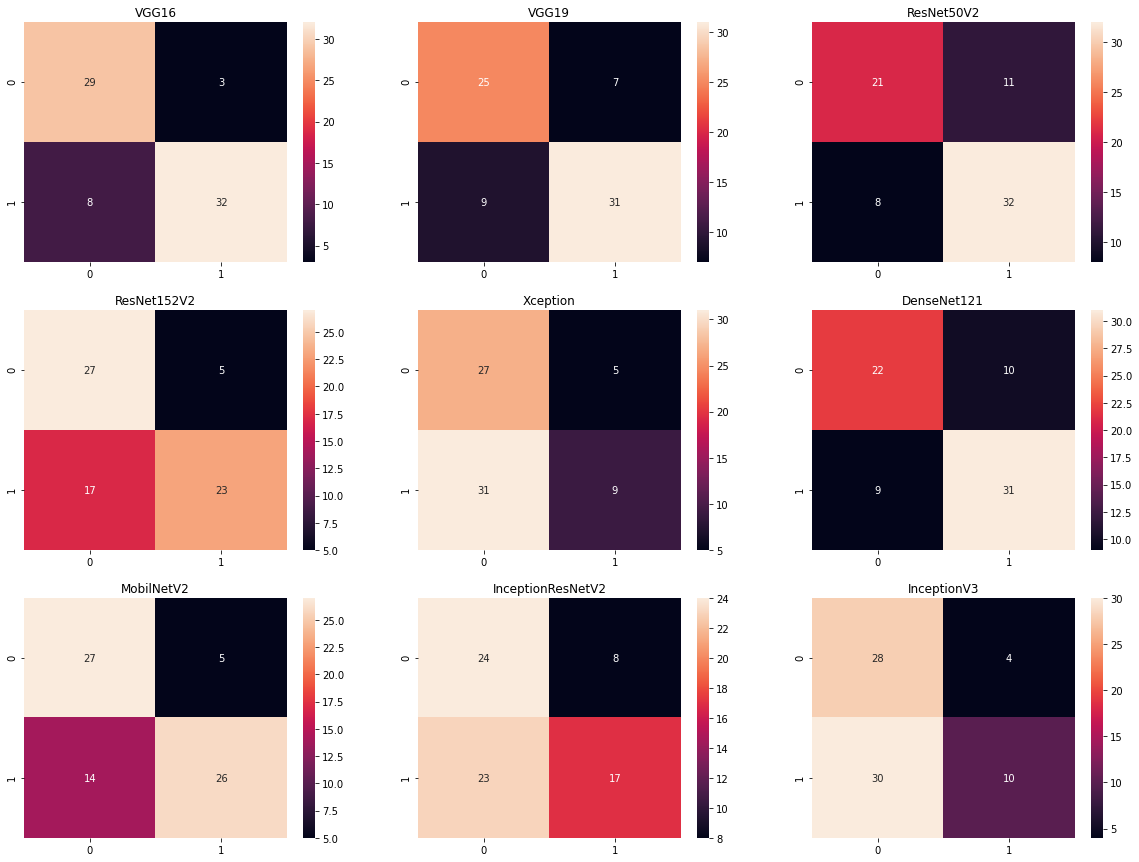

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(331)
MakeHeatmap('VGG16.h5',x_test,y_test)
plt.subplot(332)
MakeHeatmap('VGG19.h5',x_test,y_test)
plt.subplot(333)
MakeHeatmap('ResNet50V2.h5',x_test,y_test)
plt.subplot(334)
MakeHeatmap('ResNet152V2.h5',x_test,y_test)
plt.subplot(335)
MakeHeatmap('Xception.h5',x_test,y_test)
plt.subplot(336)
MakeHeatmap('DenseNet121.h5',x_test,y_test)
plt.subplot(337)
MakeHeatmap('MobilNetV2.h5',x_test,y_test)
plt.subplot(338)
MakeHeatmap('InceptionResNetV2.h5',x_test,y_test)
plt.subplot(339)
MakeHeatmap('InceptionV3.h5',x_test,y_test)
plt.show()

The best result is made by the VGG16 as we see.
Lets go further with this. Try to teach further some of the CNN layers

#Unfreeze some of the CNN weights

In [ ]:
model = TransferLearningModel('VGG16')
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
for layer in model.layers[:15]: #the layers's weight above the 10.layer are trainable now
       layer.trainable = False
for layer in model.layers[15:]:
       layer.trainable = True

In [ ]:
checkpointer=ModelCheckpoint(filepath='VGG16_unfrost.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.5417
Epoch 00001: val_loss improved from inf to 0.60016, saving model to VGG16_unfrost.h5
15/15 [==============================] - 1s 100ms/step - loss: 0.7931 - accuracy: 0.5417 - val_loss: 0.6002 - val_accuracy: 0.6953
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.5754
Epoch 00002: val_loss did not improve from 0.60016
15/15 [==============================] - 1s 78ms/step - loss: 0.7405 - accuracy: 0.5754 - val_loss: 0.6245 - val_accuracy: 0.5234
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.5711
Epoch 00003: val_loss improved from 0.60016 to 0.56018, saving model to VGG16_unfrost.h5
15/15 [==============================] - 1s 88ms/step - loss: 0.6754 - accuracy: 0.5711 - val_loss: 0.5602 - val_accuracy: 0.7500
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.6412
Epoch 00

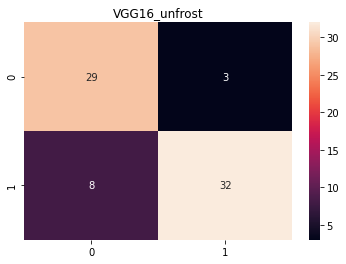

In [ ]:
MakeHeatmap('VGG16_unfrost.h5',x_test,y_test)

As we can see the result is almost the same as before, maybe a bit better.


# Load more data

We downloaded data from 3 different soucrces in the beginning of the code, but now we have to organize it properly to be able to use the flow_from_directory function. (We have to use DataGenerator functions, because there is not enough RAM available to store all the images.)

In [ ]:
covid_all = []
notcovid_all = []

image_path = '/content/covid-chestxray-dataset/images'
image_names=os.listdir(image_path)
with open('/content/covid-chestxray-dataset/metadata.csv') as csv_file: #load the csv from the session storage
    csv_reader = csv.reader(csv_file, delimiter=',') # ',' is the separating character
    for row in csv_reader:
        if row[23] in image_names: # check if we have the x-ray image for this diagnosis
            if row[5]=='Y': #positive covid test
                covid_all.append(os.path.join(image_path, row[23]))
            if row[5]=='': # negative covid test
                notcovid_all.append(os.path.join(image_path, row[23]))

image_path = '/content/Figure1-COVID-chestxray-dataset/images'
image_names=os.listdir(image_path)
with open('/content/Figure1-COVID-chestxray-dataset/metadata.csv', encoding='latin1') as csv_file: #load the csv from the session storage
    csv_reader = csv.reader(csv_file, delimiter=',') # ',' is the separating character
    for row in csv_reader:
        if (row[0]+'.jpg') in image_names: # check if we have the x-ray image for this diagnosis
            if row[4] == 'COVID-19': #positive covid test
                covid_all.append(os.path.join(image_path, row[0]+'.jpg'))
            else: # negative covid test
                notcovid_all.append(os.path.join(image_path, row[0]+'.jpg'))

image_path = '/content/Actualmed-COVID-chestxray-dataset/images'
image_names=os.listdir(image_path)
with open('/content/Actualmed-COVID-chestxray-dataset/metadata.csv') as csv_file: #load the csv from the session storage
    csv_reader = csv.reader(csv_file, delimiter=',') # ',' is the separating character
    for row in csv_reader:
        if row[10] in image_names: # check if we have the x-ray image for this diagnosis
            if row[4] == 'COVID-19': #positive covid test
                covid_all.append(os.path.join(image_path, row[10]))
            else: # negative covid test
                notcovid_all.append(os.path.join(image_path, row[10]))

covid_path = '/content/COVID-19 Radiography Database/COVID-19'
covid_names = os.listdir(covid_path)
for row in covid_names:
    covid_all.append(os.path.join(covid_path, row))
normal_path = '/content/COVID-19 Radiography Database/NORMAL'
normal_names = os.listdir(normal_path)
for row in normal_names:
    notcovid_all.append(os.path.join(normal_path, row))
pneumonia_path = '/content/COVID-19 Radiography Database/Viral Pneumonia'
pneumonia_names = os.listdir(pneumonia_path)
for row in pneumonia_names:
    notcovid_all.append(os.path.join(pneumonia_path, row))

In [ ]:
covid_train, covid_tmp = train_test_split(covid_all, test_size=0.3, shuffle=True)
covid_valid, covid_test = train_test_split(covid_tmp, test_size=0.33, shuffle=True)

notcovid_train, notcovid_tmp = train_test_split(notcovid_all, test_size=0.3, shuffle=True)
notcovid_valid, notcovid_test = train_test_split(notcovid_tmp, test_size=0.33, shuffle=True)

In [ ]:
train_dir = '/content/train'
valid_dir = '/content/valid'
test_dir = '/content/test'

In [ ]:
def convert_and_copy(filename, where):
    img = cv2.imread(filename, 0)
    rgb = np.stack((img,img,img), axis=2)
    im = Image.fromarray(rgb)
    im.save(os.path.join(where, filename.split('/')[-1]))

try:
  os.mkdir(train_dir)
  os.mkdir(os.path.join(train_dir, 'b_covid'))
  os.mkdir(os.path.join(train_dir, 'a_notcovid'))
except:
  print('Train folder already exists.')
for i in covid_train:
  convert_and_copy(i, os.path.join(train_dir, 'b_covid'))
for i in notcovid_train:
  convert_and_copy(i, os.path.join(train_dir, 'a_notcovid'))

try:
  os.mkdir(valid_dir)
  os.mkdir(os.path.join(valid_dir, 'b_covid'))
  os.mkdir(os.path.join(valid_dir, 'a_notcovid'))
except:
  print('Validation folder already exists.')
for i in covid_valid:
  convert_and_copy(i, os.path.join(valid_dir, 'b_covid'))
for i in notcovid_valid:
  convert_and_copy(i, os.path.join(valid_dir, 'a_notcovid'))

try:
  os.mkdir(test_dir)
  os.mkdir(os.path.join(test_dir, 'b_covid'))
  os.mkdir(os.path.join(test_dir, 'a_notcovid'))
except:
  print('Test folder already exists.')
for i in covid_test:
  convert_and_copy(i, os.path.join(test_dir, 'b_covid'))
for i in notcovid_test:
  convert_and_copy(i, os.path.join(test_dir, 'a_notcovid'))

Now the images have been copied to our properly organized folders, so we can delete the downloaded folders to save up disk space.

In [ ]:
!rm -rf '/content/covid-chestxray-dataset'
!rm -rf '/content/Figure1-COVID-chestxray-dataset'
!rm -rf '/content/Actualmed-COVID-chestxray-dataset'
!rm -rf '/content/COVID-19 Radiography Database'

Load the previously trained model for transfer learning.

In [ ]:
model = load_model('VGG16_unfrost.h5')
for layer in model.layers[:15]: #the layers's weight above the 10.layer are trainable now
       layer.trainable = False
for layer in model.layers[15:]:
       layer.trainable = True
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.15, rotation_range=20, zoom_range=15, height_shift_range=0.2, width_shift_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=True)
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=True)

Found 2738 images belonging to 2 classes.
Found 785 images belonging to 2 classes.


In [ ]:
checkpointer = ModelCheckpoint(filepath='VGG16_bigdata.h5', save_best_only=True, verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
modelHistory = model.fit_generator(train_generator, steps_per_epoch=20, validation_data=valid_generator, validation_steps=5, epochs=4, callbacks=[checkpointer, earlystopping])

Epoch 1/4
20/20 [==============================] - ETA: 0s - loss: 0.8084 - accuracy: 0.7734
Epoch 00001: val_loss improved from inf to 0.49293, saving model to VGG16_bigdata.h5
20/20 [==============================] - 38s 2s/step - loss: 0.8084 - accuracy: 0.7734 - val_loss: 0.4929 - val_accuracy: 0.8000
Epoch 2/4
20/20 [==============================] - ETA: 0s - loss: 0.5475 - accuracy: 0.7875
Epoch 00002: val_loss did not improve from 0.49293
20/20 [==============================] - 36s 2s/step - loss: 0.5475 - accuracy: 0.7875 - val_loss: 0.5055 - val_accuracy: 0.8000
Epoch 3/4
20/20 [==============================] - ETA: 0s - loss: 0.4653 - accuracy: 0.8297
Epoch 00003: val_loss did not improve from 0.49293
20/20 [==============================] - 37s 2s/step - loss: 0.4653 - accuracy: 0.8297 - val_loss: 0.4965 - val_accuracy: 0.8062
Epoch 4/4
20/20 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.8203
Epoch 00004: val_loss did not improve from 0.49293
20/

In [ ]:
x_test_bigdata= []
y_test_bigdata= []

covid_test_path = '/content/test/b_covid'
covid_test_names = os.listdir(covid_test_path)
for i in covid_test_names:
    img = cv2.imread(os.path.join(covid_test_path, i)) # load the image
    
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) # resize the image to 224*224
    x_test_bigdata.append(img)
    y_test_bigdata.append(True)
notcovid_test_path = '/content/test/a_notcovid'
notcovid_test_names = os.listdir(notcovid_test_path)
for i in notcovid_test_names:
    img = cv2.imread(os.path.join(notcovid_test_path, i)) # load the image
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) # resize the image to 224*224
    x_test_bigdata.append(img)
    y_test_bigdata.append(False)

x_test_bigdata = np.asarray(x_test_bigdata)
y_test_bigdata = np.asarray(y_test_bigdata)

x_test_bigdata = x_test_bigdata.astype(float)

x_test_bigdata = x_test_bigdata/255

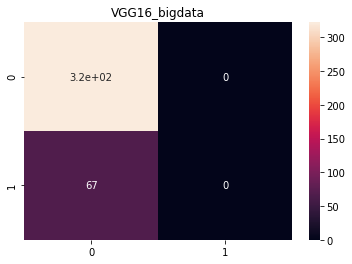

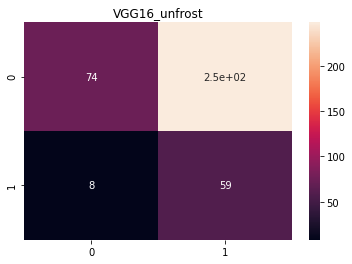

In [ ]:
MakeHeatmap('VGG16_bigdata.h5',x_test_bigdata,y_test_bigdata)
plt.show()
MakeHeatmap('VGG16_unfrost.h5',x_test_bigdata,y_test_bigdata)
plt.show()

Lets take a closer look at the predicts

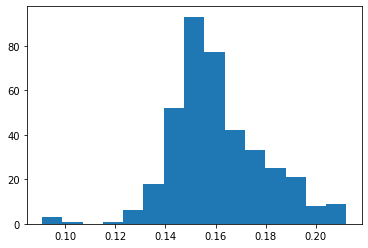

In [ ]:
model=load_model('VGG16_bigdata.h5')
predict = model.predict(x_test_bigdata)
plt.hist(predict[:,0], bins = 15)
plt.show()

In [ ]:
#lets separate the test data according the result
FN = 0
FP = 0
TN = 0
TP = 0
false_negative= []
false_positive= []
true_negative= []
true_positive= []
uncertain= []
best0=np.zeros([1,224,224,3]) #the best predict when the result was true positive
best1=np.zeros([1,224,224,3]) #the best predict when the result was true negative
max=0;
min=1;
for i in range(len(predict)):
  if (predict[i]<0.5 and y_test_bigdata[i]): #
    false_negative.append(x_test_bigdata[i])
    FN = FN+1
  elif (predict[i]>=0.5 and y_test_bigdata[i]==0):
    false_positive.append(x_test_bigdata[i])
    FP = FP+1
  elif (predict[i]>=0.5 and y_test_bigdata[i]):
    true_positive.append(x_test_bigdata[i])
    TP = TP+1
    if (predict[i]>max):
      best1[0,:,:,:]=x_test_bigdata[i]
      max=predict[i]
  elif (predict[i]<0.5 and y_test_bigdata[i]==0):
    true_negative.append(x_test_bigdata[i])
    TN = TN+1
    if (predict[i]<min):
      best0[0,:,:,:]=x_test_bigdata[i]
      min=predict[i]
#another separation: check when the network was not confident in the decission
  if (predict[i]>=0.4 and predict[i]<=0.55):
    uncertain.append(x_test_bigdata[i])

f_n = np.asarray(false_negative)

f_p = np.asarray(false_positive)

t_n = np.asarray(true_negative)

t_p = np.asarray(true_positive)

uc = np.asarray(uncertain)

print(f_n.shape)
print(f_p.shape)
print(t_n.shape)
print(t_p.shape)
print(uc.shape)

(67, 224, 224, 3)
(0,)
(322, 224, 224, 3)
(0,)
(0,)


In [ ]:
accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
specificity = TN/(TN+FP)
#precision = TP/(TP+FP)

print('accuracy:', accuracy)
print('recall: ', recall)
print('specificity', specificity)
#print('precision:', precision)

accuracy: 0.8277634961439588
recall:  0.0
specificity 1.0
